### Activation function

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(100)
class dataset_class:
    """
    dataset iterator 
    """
    def __init__(self,inputs,targets):
        self.inputs = inputs
        self.targets = targets
        self.limit   = len(targets)
        
        
    def __iter__(self): 
        self.counter = 0 
        return self
    
    def __next__(self): 
  
        # Store current value ofx 
        self.counter  
  
   
        if self.counter >= self.limit: 
            raise StopIteration 
        x = self.counter
        # Else increment and return old value 
        
        self.counter  = self.counter + 1 
        return self.inputs[x],self.targets[x] 
    
    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y
        


def generate_data_set(sample_size = 100):
    """
    Generate some none linear X- y paris, with time dependency
    
    """
    Xs = []
    Ys = []
    
    def non_linear_y(x):
        """
        Nonlinearity
        """
        return ((np.sin(x[0]*2*3.14)*x[1] + x[2] ) *2)
 
    for num in range(sample_size):
        """
        Time dependency(copy data by *2 )
        """
        copys=np.random.randint(1,5)
        x = [np.random.uniform(0,1,(3,1)) for i in range (copys) ]*2
        y = [non_linear_y(i) for i in x] 
        Xs.append(list(x))
        Ys.append(list(y))
        
    return  dataset_class(Xs,Ys)



training_set = generate_data_set(sample_size = 100)
validation_set = generate_data_set(sample_size = 100)
test_set = generate_data_set(sample_size = 20)

## start implementation of LSTM

In [3]:
def sigmoid(x,derivative = False):
    """
    Sigmid
    """
    if derivative:
         # if derititive it is a function from y to dy
        return x*(1 - x)
    return np.exp(x) /(1 +np.exp(x) )

def tanh(x,derivative = False):
    """
    tanh function
    """
    if derivative:
        return 1 - x*x
    return np.tanh(x)

def softmax(x):
    """
    softmax: for classification 
    """
    return np.exp(x)/np.sum( np.exp(x))
    
 

### LSTM 

In [4]:


def init_lstm(X_size,Y_size,H_size,Z_size ):
    """
    initialize parameters for lstm
    W_f , b_f   - forget gate
    W_i,  b_i   - input gate
    W_c,  b_c   - candidates
    W_o,  b_o   - output gate 
    
    
    W_v,b_v   
    """
    W_f = np.random.randn(H_size,Z_size)
    b_f = np.ones((H_size,1))
    
    W_i = np.random.randn(H_size,Z_size)
    b_i = np.zeros((H_size,1))
    
    W_c = np.random.randn(H_size,Z_size)
    b_c = np.zeros((H_size,1))
    
    W_o =  np.random.randn(H_size,Z_size)
    b_o =  np.zeros((H_size,1))
    
    
    ## from hidden layer to output
    
    W_v = np.random.randn(Y_size,H_size)
    b_v = np.zeros((Y_size,1))
    
    return W_f,b_f,W_i,b_i,W_c,b_c,W_o,b_o,W_v,b_v

### test forwardation 

In [5]:
def forward_pass(params,x,h_prev,c_prev):
    """
    forward porpergation - given input return output
    
    """
    W_f,b_f,W_i,b_i,W_g,b_g,W_o,b_o,W_v,b_v = params
 
    z = np.concatenate([h_prev,x])
 
    # fortegt gate
    f = sigmoid (W_f.dot(z) + b_f)
    # input gate
    i = sigmoid (W_i.dot(z) + b_i) 
    # candidates
    g = tanh(W_g.dot(z) + b_g)  
    # update c
    c = c_prev*f + i*g
    #out put
    o = sigmoid (W_o.dot(z) + b_o)
    # update hidden state
    h = o*tanh(c)
    ## Parts related to out put function - to be modified
    v = W_v.dot(h) + b_v
    ## calculate softmax
    output = v#softmax(v)
    return z,f,i,g,c,o,h,v,output
        
        

In [6]:



def backward_pass(params,d_params,target ,z ,f,i ,g ,c ,o ,h ,v ,output, d_h_next,d_c_next,C_prev):
    """
    backpropagation
    """
    W_f,b_f,W_i,b_i,W_g,b_g,W_o,b_o,W_v,b_v  = params
    d_W_f,d_b_f,d_W_i,d_b_i,d_W_g,d_b_g,d_W_o,d_b_o,d_W_v,d_b_v = d_params


 



    # now evaluate loss and take derivitive 
    #d_v =np.copy( output)
    #d_v[target.astype(bool)]-= 1
    
    
    d_v  = output - target
 


    #update weight in output function
    d_W_v +=  (d_v)*(h.T)
    d_b_v += d_v

    #from output layer to lstm output h
    d_h  =W_v.T.dot(d_v) 
    d_h += d_h_next#(dL_t/dh_t + dL_t+1 /dh_t )

    # from h to output gate
    d_o = d_h * tanh(c)
    # from output gate to z  
    d_o = d_o* sigmoid(o,True)  
    d_W_o  += d_o*(z.T)  
    d_b_o  += d_o
    # from output(tanh) gate to C

    d_c = np.copy(d_c_next)
    d_c += d_h * o*tanh(tanh(c),True)
    # from C to gain g
    d_g = d_c*i
    d_g *= tanh(g,True)
    # now we can calculate derivitive in g
    d_W_g += d_g *(z.T)
    d_b_g += d_g 
    # now wrt i
    d_i = d_c*g
    d_i = d_i*sigmoid(i,True)
    d_W_i += d_i *z.T
    d_b_i += d_i

    # now wrt forget gate
    d_f = C_prev*d_c
    d_f = d_f*sigmoid(f,True)
    d_W_f += d_f *z.T
    d_b_f += d_f



    d_z = W_f.T.dot(d_f) + W_i.T.dot(d_i) + W_g.T.dot(d_g) + W_o.T.dot(d_o)
    d_h_prev = d_z[:len(d_h_next)]
    d_c_prev = f*d_c

    return d_h_prev,d_c_prev

### test backwardation 

In [7]:

def forward_backward(inputs,targets,params,h_prev,c_prev):
    x_s,z_s,f_s,i_s = {},{},{},{}
    g_s,c_s,o_s,h_s = {},{},{},{}
    v_s,y_s         = {},{} 

    h_s[-1],c_s[-1] = h_prev,c_prev

    loss = 0
    for t in range(len(inputs)):
        x_s[t] = inputs[t]
        z_s[t],f_s[t],i_s[t] ,g_s[t],c_s[t],o_s[t],h_s[t],v_s[t],y_s[t] = \
        forward_pass(params,x_s[t],h_s[t-1],c_s[t-1])
        
        #-np.mean(targets[t] *(np.log(y_s[t]+ 1e-12 ) ) )
        loss +=     ((targets[t] - y_s[t])**2)[0][0]

    d_params = ([np.zeros(param.shape) for param in params])
    d_h_next,d_c_next = np.zeros(h_prev.shape),np.zeros(c_prev.shape)

    for t in reversed(range(len(inputs))):

        target = targets[t]
        d_h_next,d_c_next  =  backward_pass(params,d_params,target = target ,z = z_s[t] ,f = f_s[t],\
                      i = i_s[t] ,g = g_s[t] ,c = c_s[t] ,o = o_s[t] ,h = h_s[t] ,v = v_s[t] ,\
                      output = y_s[t], d_h_next = d_h_next,d_c_next = d_c_next,C_prev = c_s[t-1])
        
    return loss, d_params,h_s[len(h_s) - 2], c_s[len(c_s) - 2]

In [8]:
def update_params(params,d_params,learning_rate = 1e-3):
 
    for param, grad in zip(params, d_params):
        param -= learning_rate  * grad
       
    return params
    

In [9]:

def clip_gradient(d_params):
    for dp in d_params:
        np.clip(dp, -1, 1, out=dp)

def predict(inputs,targets,params,h_prev,c_prev):
    x_s,z_s,f_s,i_s = {},{},{},{}
    g_s,c_s,o_s,h_s = {},{},{},{}
    v_s,y_s         = {},{} 

    h_s[-1],c_s[-1] = h_prev,c_prev

    loss = 0
    for t in range(len(inputs)):
        x_s[t] = inputs[t]
        z_s[t],f_s[t],i_s[t] ,g_s[t],c_s[t],o_s[t],h_s[t],v_s[t],y_s[t] = \
        forward_pass(params,x_s[t],h_s[t-1],c_s[t-1])
        loss +=    ((targets[t] - y_s[t])**2)[0][0]
    return  loss ,y_s
 

In [10]:
num_epochs = 500

X_size,Y_size,H_size = 3,1,50
Z_size = X_size + H_size

params = init_lstm(X_size,Y_size,H_size,Z_size)

training_losses = []
validation_losses = []
for epoch in range(num_epochs):
    training_loss = 0 
    validation_loss = 0
    for train_X, train_y in training_set:
        h_prev,c_prev = np.zeros((H_size,1)) , np.zeros((H_size,1))
        inputs =  train_X
        targets = train_y
        
        loss, d_params,h_prev,c_prev = forward_backward(inputs,targets,params,h_prev,c_prev)
        clip_gradient(d_params )
        
        update_params(params,d_params,learning_rate = 1e-3)
 
        training_loss += loss
    for validate_X,validate_y in validation_set:
        h_prev,c_prev = np.zeros((H_size,1)) , np.zeros((H_size,1))
        inputs =  train_X
        targets = train_y
        loss,_ = predict(inputs,targets,params,h_prev,c_prev)
         
        validation_loss += loss
    
    
    training_losses.append(training_loss/len(training_set))
    validation_losses.append(validation_loss/len(validation_set))

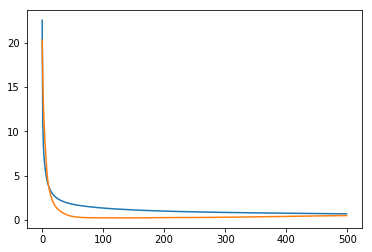

In [11]:
plt.plot(training_losses)
plt.plot(validation_losses)

In [12]:
test_loss = 0 
for test_X,test_y in test_set:
    h_prev,c_prev = np.zeros((H_size,1)) , np.zeros((H_size,1))
    inputs =  test_X
    targets = test_y
    loss,y= predict(inputs,targets,params,h_prev,c_prev)

    test_loss += loss
test_loss/len( test_set)

2.4007431312900005

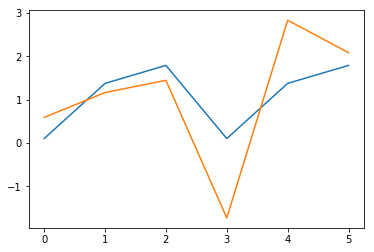

In [13]:
plt.plot([x[0] for x in targets])
plt.plot([v[0][0] for i,v in y.items()])